In [446]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Testes de hipótese

## Objetivos são importantes para vencer uma partida?
## Eliminar jogadores inimigos é importante para vencer uma partida?
## O acesso a visão de mapa é importante para vencer uma partida?
## O “first blood” é determinante para a vitória da equipe?

## Carregando a primeira base de dados (com algumas manipulações realizadas na secção de análise exploratória). Base referente a partidas não-profissionais do servidor lest europeu (EUW).

In [447]:
df = pd.read_csv('gamesExt.csv')
df = df.drop(['Unnamed: 0'], axis=1)

In [448]:
df.head()

,towerKillsDiff,inhibitorKillsDiff,baronKillsDiff,dragonKillsDiff,riftHeraldDiff,gameId,creationTime,gameDuration,seasonId,winner,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,6,1,2,2,-1,3326086514,1504279457970,1949,9,1,...,5,0,0,1,1,114,67,43,16,51
1,8,4,0,2,1,3229566029,1497848803862,1851,9,1,...,2,0,0,0,0,11,67,238,51,420
2,6,1,1,0,0,3327363504,1504360103310,1493,9,1,...,2,0,0,1,0,157,238,121,57,28
3,9,2,1,2,0,3326856598,1504348503996,1758,9,1,...,0,0,0,0,0,164,18,141,40,51
4,6,2,1,2,0,3330080762,1504554410899,2094,9,1,...,3,0,0,1,0,86,11,201,122,18


### Algumas funções que realizam as operações necessárias

In [449]:
def compara(df, atributo1, atributo2, pr=0):
    soma = (df[atributo1] == df[atributo2]).sum()
    somaVazio = (df[atributo2] == 0).sum()
    n = df[atributo1].size
    porcentagem = round(soma*100/n,2)
    porcentagemVazio = round(somaVazio*100/n,2)
    if(pr):
        print("Em {}% das partidas as equipes '{}' também conseguem '{}'. {}% das partidas não ocorre '{}'"
              .format(porcentagem, atributo1, atributo2, porcentagemVazio, atributo2))
    return porcentagem

In [450]:
def perm_first(df, atributo1, atributo2, samplesnumber, it=500):
    
    df_copy = df.copy()
    df_copy = df_copy.sample(samplesnumber)

    print("com {} amostras".format(samplesnumber))

    lista = []
    taxaObs = compara(df_copy, atributo1, atributo2, 1)
    df_copy[atributo1] = df_copy[atributo1].copy()
    
    for i in range(it):
        df_copy[atributo1] = np.random.permutation(df_copy[atributo1])
        lista.append(compara(df_copy, atributo1, atributo2, 0))

    plt.figure(figsize=(16, 8))
    plt.hist(lista, bins=30)
    plt.title("Partidas com equipes {} e {}, utilizando {} amostras".format(atributo1, atributo2, samplesnumber))
    inf = np.percentile(lista, 5)
    sup = np.percentile(lista, 95)
    plt.axvline(x=inf,c='red')
    plt.axvline(x=sup,c='red')
    plt.axvline(x=taxaObs,c='green')
    ax = plt.gca()

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)

In [451]:
def novo_atr_diff(df, str1, str2, novaStr, index, winflag, winVal):
    df.insert(index, novaStr, df[str1] - df[str2])
    for index, value in df[winflag].items():
        if value == winVal:
            df[novaStr][index] = -df[novaStr][index]

In [452]:
def diff(df, atributo1, atributo2, winflag):
    winTeam = df.groupby([winflag]).mean()[[atributo1, atributo2]]
    diff = abs(winTeam[atributo1] - winTeam[atributo2]).mean()
    return diff

In [453]:
def diff2(df, atributo, winflag):
    X = df.groupby([winflag])[atributo].mean()
    diff = X[1] - X[0]
    return diff

In [454]:
def perm_diff(df, atributo1, atributo2, winflag, samplesnumber, it=500):
    df_copy = df.copy()
    df_copy = df_copy.sample(samplesnumber)
    lista = []
    taxaObs = diff(df_copy, atributo1, atributo2, winflag)
    print("com {} amostras".format(samplesnumber))
    print("diferença de {} observada entre equipe vencedora e perdedora : {}".format(atributo1, taxaObs))

    for i in range(it):
        if i % 250 == 0: print("iteracoes: {}/{}".format(i, it))
        winArray = np.random.permutation(df_copy[winflag])
        df_copy[winflag] = winArray
        lista.append(diff(df_copy, atributo1, atributo2, winflag))
        
    plt.figure(figsize=(16, 8))
    plt.hist(lista, bins=30)
    inf = np.percentile(lista, 5)
    sup = np.percentile(lista, 95)
    plt.title('Intervalo de confiança gerado por permutação utilizando {} amostras'.format(samplesnumber))
    plt.xlabel('Diferença de {} entre as equipes que conseguiram a vitória e as que não conseguiram'.format(atributo1, winflag))
    plt.axvline(x=inf,c='red')
    plt.axvline(x=sup,c='red')
    plt.axvline(x=taxaObs,c='green')
    ax = plt.gca()

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)

In [455]:
def perm_diff2(df, atributo, winflag, samplesnumber, it=1000):
    df_copy = df.copy()
    df_copy = df_copy.sample(samplesnumber)
    lista = []
    taxaObs = diff2(df_copy, atributo, winflag)
    print("com {} amostras".format(samplesnumber))
    print("diferença de {} observada entre {} e não {} : {}".format(atributo, winflag, winflag, taxaObs))

    for i in range(it):
        if i % 250 == 0: print("iteracoes: {}/{}".format(i, it))
        winArray = np.random.permutation(df_copy[winflag])
        df_copy[winflag] = winArray
        lista.append(diff2(df_copy, atributo, winflag))
        
    plt.figure(figsize=(16, 8))
    plt.hist(lista, bins=30)
    plt.title('Intervalo de confiança gerado por permutação utilizando {} amostras'.format(samplesnumber))
    plt.xlabel('Diferença de {} entre os jogadores que conseguiram {} e os que não conseguiram'.format(atributo, winflag))
    inf = np.percentile(lista, 5)
    sup = np.percentile(lista, 95)
    plt.axvline(x=inf,c='red')
    plt.axvline(x=sup,c='red')
    plt.axvline(x=taxaObs,c='green')
    ax = plt.gca()

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)

## Análise da proporção de equipes que conseguem o primeiro objetivo e conseguem a vitória. Intervalo de confiança gerado usando permutação.

com 51490 amostras
Em 58.47% das partidas as equipes 'winner' também conseguem 'firstBlood'. 1.08% das partidas não ocorre 'firstBlood'
com 51490 amostras
Em 69.15% das partidas as equipes 'winner' também conseguem 'firstTower'. 2.36% das partidas não ocorre 'firstTower'
com 51490 amostras
Em 80.0% das partidas as equipes 'winner' também conseguem 'firstInhibitor'. 12.19% das partidas não ocorre 'firstInhibitor'


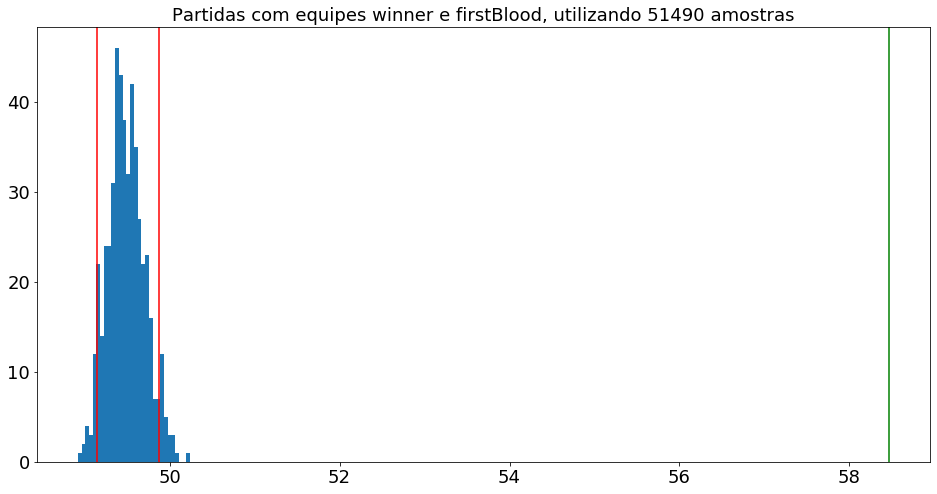

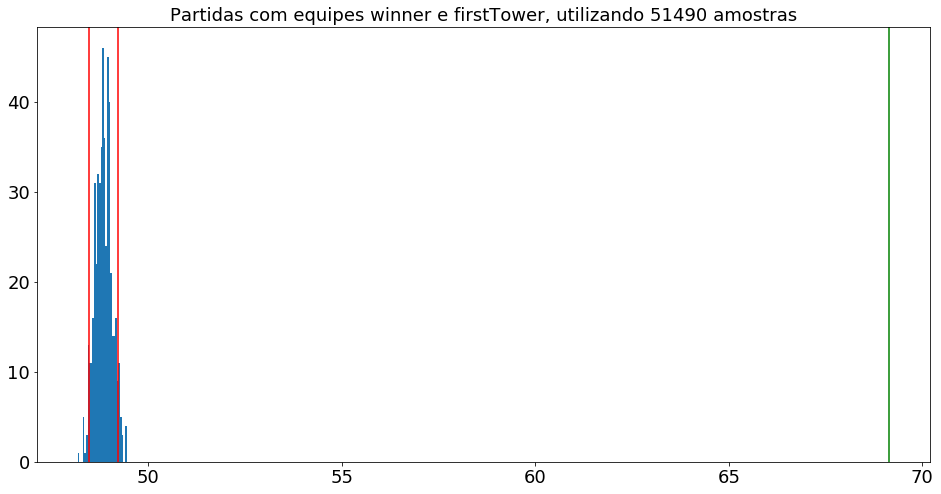

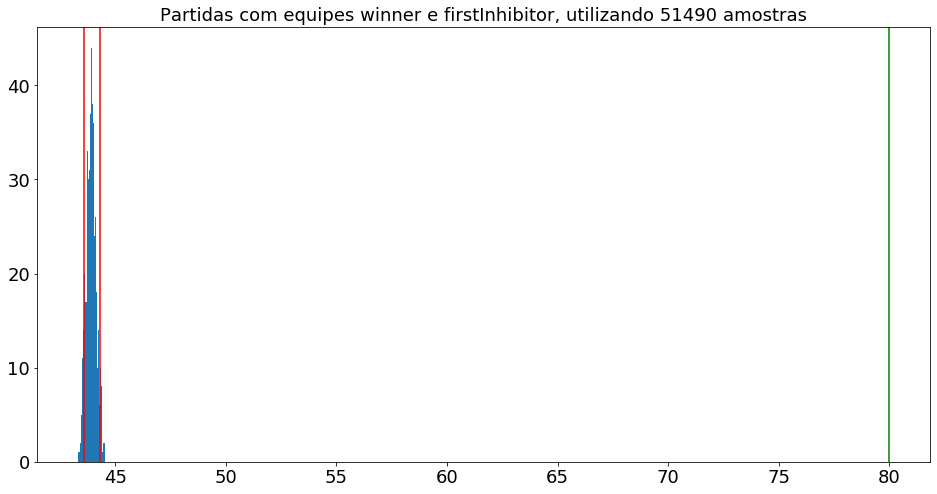

In [456]:
perm_first(df, 'winner', 'firstBlood', df.shape[0])
perm_first(df, 'winner', 'firstTower', df.shape[0])
perm_first(df, 'winner', 'firstInhibitor', df.shape[0])

com 1000 amostras
Em 57.9% das partidas as equipes 'winner' também conseguem 'firstBlood'. 0.3% das partidas não ocorre 'firstBlood'
com 10000 amostras
Em 58.29% das partidas as equipes 'winner' também conseguem 'firstBlood'. 1.06% das partidas não ocorre 'firstBlood'
com 51490 amostras
Em 58.47% das partidas as equipes 'winner' também conseguem 'firstBlood'. 1.08% das partidas não ocorre 'firstBlood'


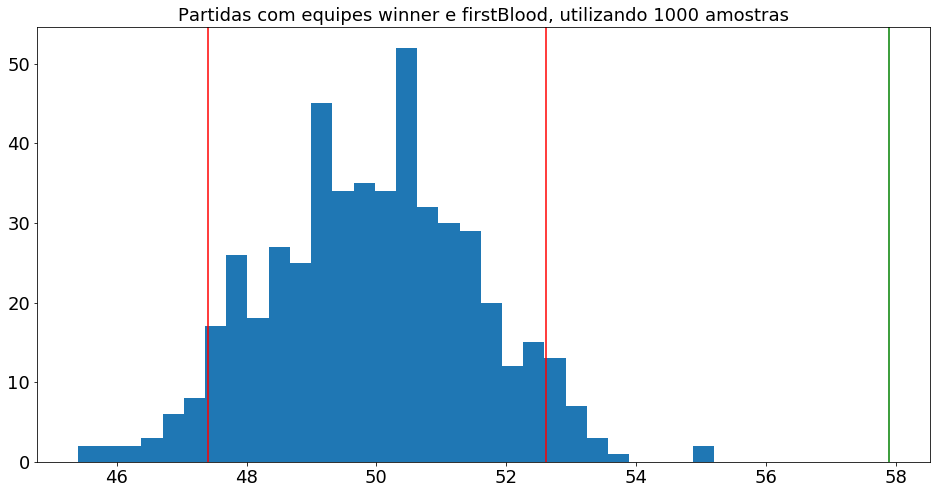

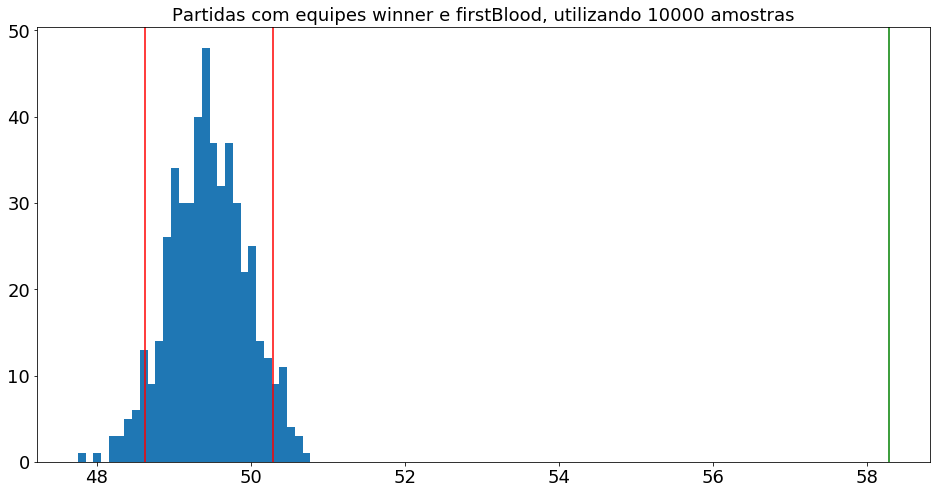

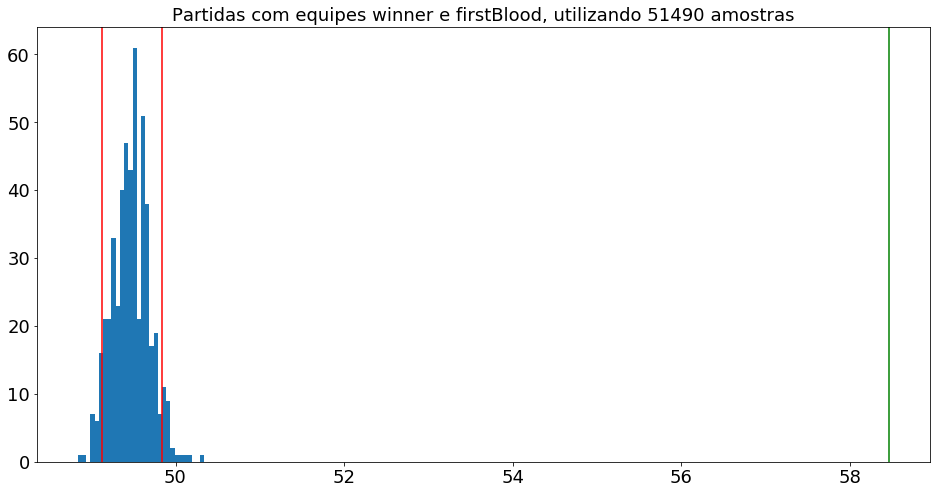

In [457]:
perm_first(df, 'winner', 'firstBlood', 1000)
perm_first(df, 'winner', 'firstBlood', 10000)
perm_first(df, 'winner', 'firstBlood', df.shape[0])

## Diferença de abates de torres entre equipe vencedora e perdedora. Intervalo de confiança gerado usando permutação.

com 1000 amostras
diferença de t1_towerKills observada entre equipe vencedora e perdedora : 6.014500232003712
iteracoes: 0/500
iteracoes: 250/500


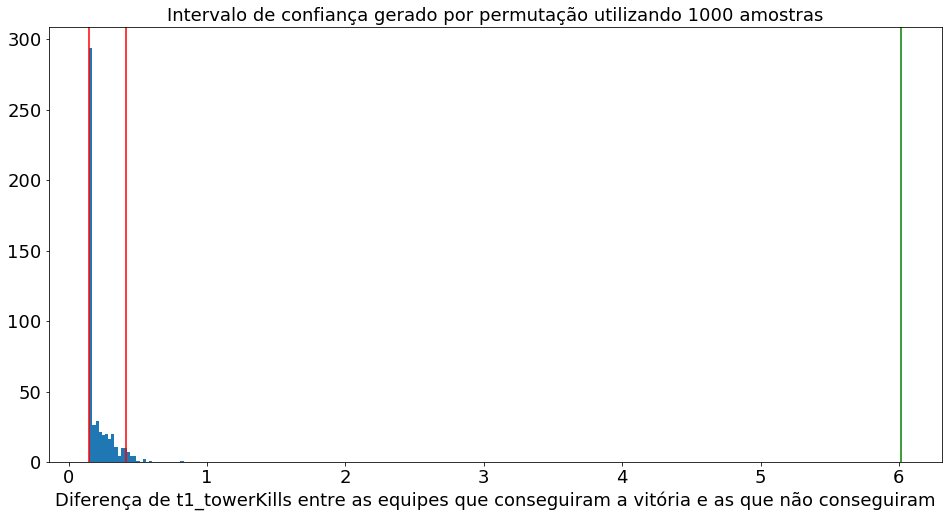

In [458]:
perm_diff(df, 't1_towerKills', 't2_towerKills', 'winner', 1000)

## Carregando segunda base de dados (com algumas manipulações realizadas na secção de análise exploratória). Base referente a partidas competitivas profisisonais.

In [459]:
df2 = pd.read_csv('LeagueofLegendsExtended.csv')
df2 = df2.drop(['Unnamed: 0'], axis=1)
df2.columns

Index(['goldred at 5 min', 'goldblue at 5 min', 'goldred at last min',
       'goldblue at last min', 'goldred at 10 min', 'goldblue at 10 min',
       'killsDiff', 'riftHeraldDiff', 'baronKillsDiff', 'dragonKillsDiff',
       'inhibitorKillsDiff', 'towerKillsDiff', 'League', 'Year', 'Season',
       'Type', 'blueTeamTag', 'bResult', 'rResult', 'redTeamTag', 'gamelength',
       'golddiff', 'goldblue', 'bKills', 'bTowers', 'bInhibs', 'bDragons',
       'bBarons', 'bHeralds', 'goldred', 'rKills', 'rTowers', 'rInhibs',
       'rDragons', 'rBarons', 'rHeralds', 'blueTop', 'blueTopChamp',
       'goldblueTop', 'blueJungle', 'blueJungleChamp', 'goldblueJungle',
       'blueMiddle', 'blueMiddleChamp', 'goldblueMiddle', 'blueADC',
       'blueADCChamp', 'goldblueADC', 'blueSupport', 'blueSupportChamp',
       'goldblueSupport', 'blueBans', 'redTop', 'redTopChamp', 'goldredTop',
       'redJungle', 'redJungleChamp', 'goldredJungle', 'redMiddle',
       'redMiddleChamp', 'goldredMiddle', 'redAD

## Análise da diferença de conquista de objetivos entre a equipe vencedora e perdedora.

com 1000 amostras
diferença de bTowers observada entre equipe vencedora e perdedora : 6.483843551180975
iteracoes: 0/500
iteracoes: 250/500


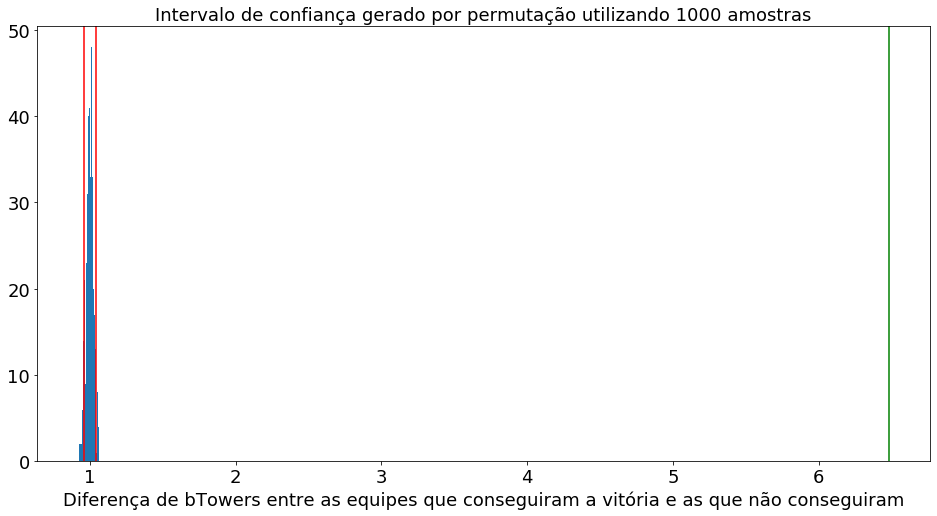

In [460]:
perm_diff(df2, 'bTowers', 'rTowers', 'bResult', 1000)

com 1000 amostras
diferença de bDragons observada entre equipe vencedora e perdedora : 1.2635758196721312
iteracoes: 0/500
iteracoes: 250/500


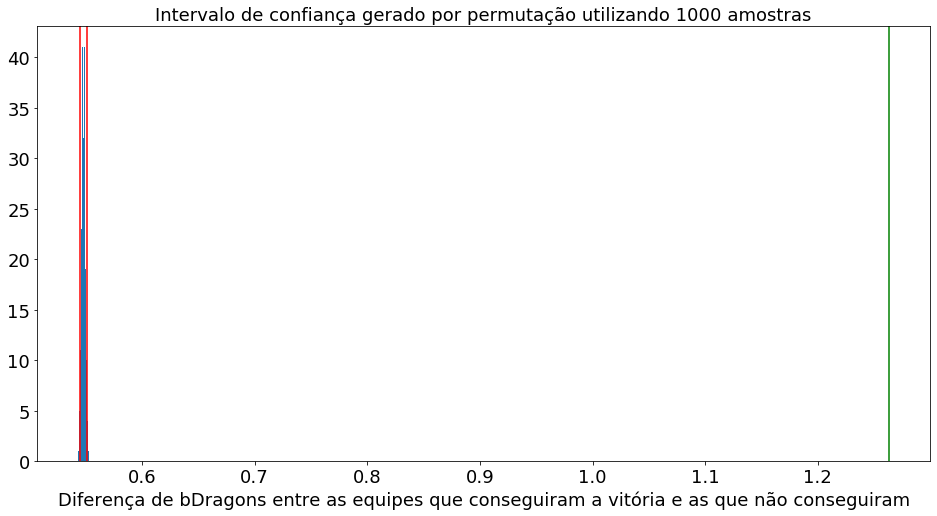

In [461]:
perm_diff(df2, 'bDragons', 'rDragons', 'bResult', 1000)

## Análise da diferença de eliminações entre a equipe vencedora e perdedora.

com 1000 amostras
diferença de bKills observada entre equipe vencedora e perdedora : 8.744694894963839
iteracoes: 0/500
iteracoes: 250/500


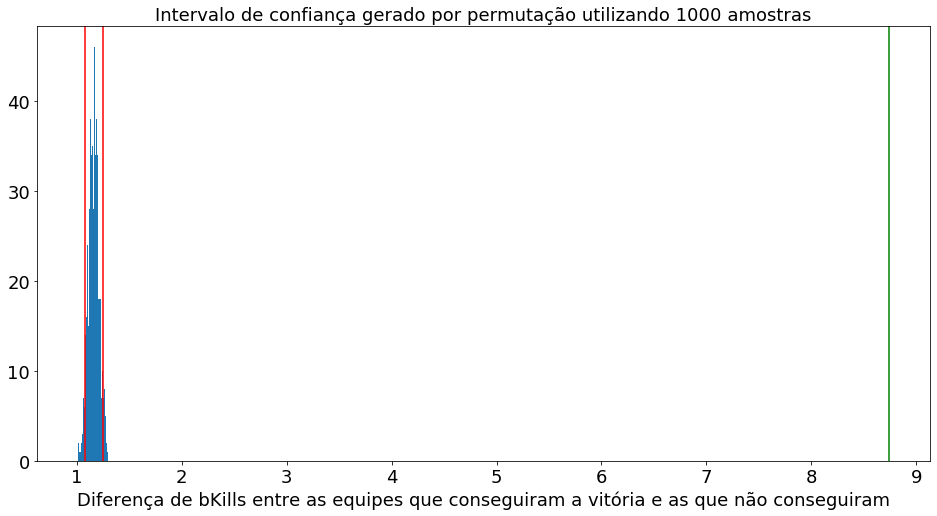

In [462]:
perm_diff(df2, 'bKills', 'rKills', 'bResult', 1000)

## Análise da diferença de ouro adquirido entre a equipe vencedora e perdedora.

com 1000 amostras
diferença de goldred at 5 min observada entre equipe vencedora e perdedora : 156.16331539298199
iteracoes: 0/500
iteracoes: 250/500


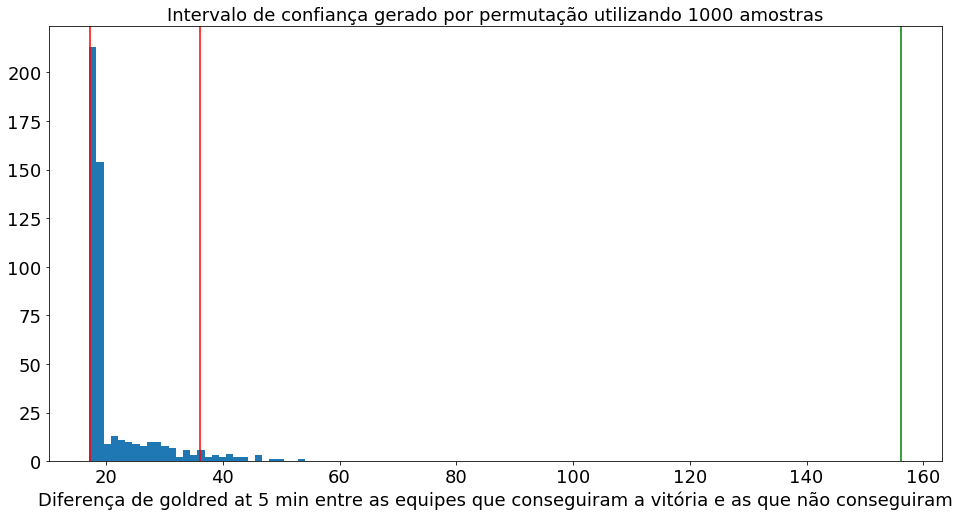

In [463]:
perm_diff(df2, 'goldred at 5 min', 'goldblue at 5 min', 'bResult', 1000)

com 1000 amostras
diferença de goldred at 10 min observada entre equipe vencedora e perdedora : 569.0414687025232
iteracoes: 0/500
iteracoes: 250/500


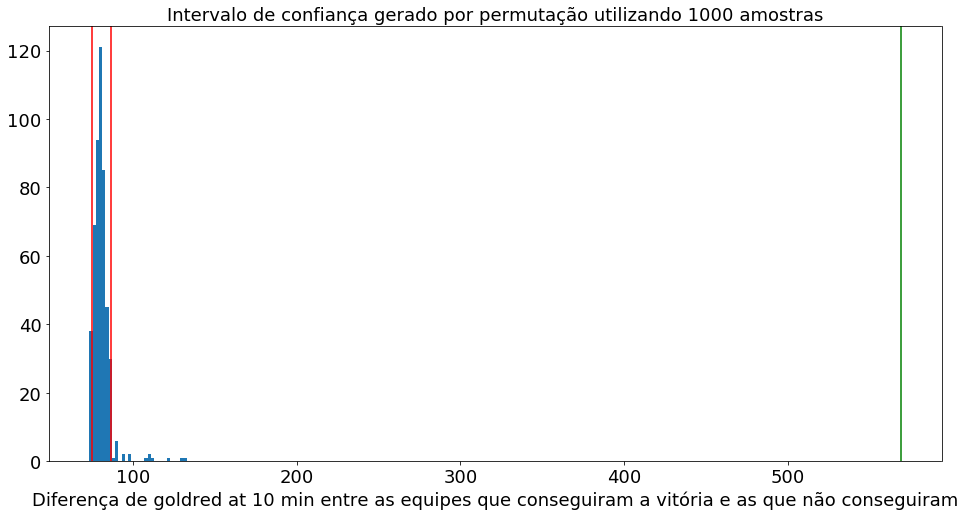

In [464]:
perm_diff(df2, 'goldred at 10 min', 'goldblue at 10 min', 'bResult', 1000)

com 1000 amostras
diferença de goldred at last min observada entre equipe vencedora e perdedora : 10193.336525974031
iteracoes: 0/500
iteracoes: 250/500


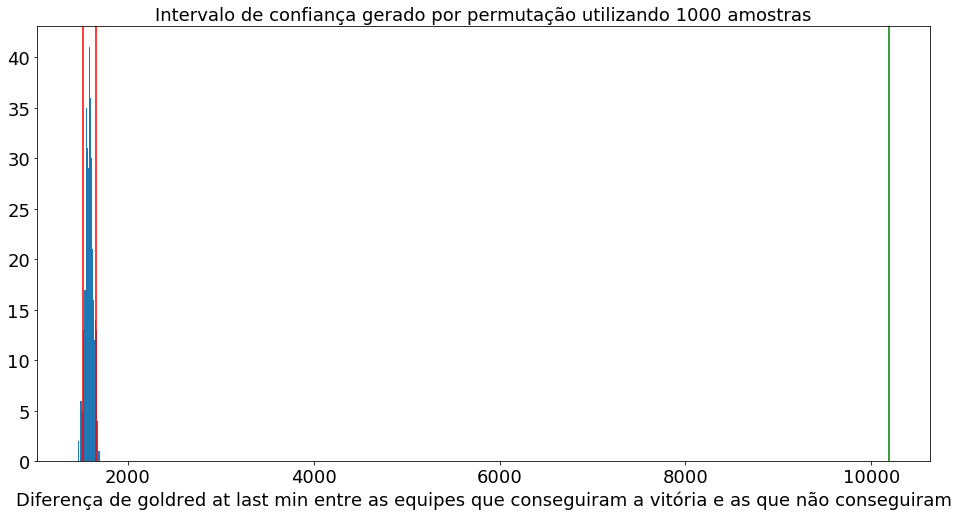

In [465]:
perm_diff(df2, 'goldred at last min', 'goldblue at last min', 'bResult', 1000)

## Carregando a terceira base de dados (com algumas manipulações realizadas na secção de análise exploratória). Base com 1 milhão de registros dados referentes a performance individual dos jogadores.

In [466]:
df3 = pd.read_csv('stats1.csv')
df3.columns

Index(['id', 'win', 'item1', 'item2', 'item3', 'item4', 'item5', 'item6',
       'trinket', 'kills', 'deaths', 'assists', 'largestkillingspree',
       'largestmultikill', 'killingsprees', 'longesttimespentliving',
       'doublekills', 'triplekills', 'quadrakills', 'pentakills',
       'legendarykills', 'totdmgdealt', 'magicdmgdealt', 'physicaldmgdealt',
       'truedmgdealt', 'largestcrit', 'totdmgtochamp', 'magicdmgtochamp',
       'physdmgtochamp', 'truedmgtochamp', 'totheal', 'totunitshealed',
       'dmgselfmit', 'dmgtoobj', 'dmgtoturrets', 'visionscore', 'timecc',
       'totdmgtaken', 'magicdmgtaken', 'physdmgtaken', 'truedmgtaken',
       'goldearned', 'goldspent', 'turretkills', 'inhibkills',
       'totminionskilled', 'neutralminionskilled', 'ownjunglekills',
       'enemyjunglekills', 'totcctimedealt', 'champlvl', 'pinksbought',
       'wardsbought', 'wardsplaced', 'wardskilled', 'firstblood'],
      dtype='object')

## Análise da diferença de performance relacionada a visão de mapa entre a equipe vencedora e perdedora.

com 1000 amostras
diferença de visionscore observada entre win e não win : 2.1673226771628347
iteracoes: 0/1000
iteracoes: 250/1000
iteracoes: 500/1000
iteracoes: 750/1000
com 10000 amostras
diferença de visionscore observada entre win e não win : 2.2190783167286234
iteracoes: 0/1000
iteracoes: 250/1000
iteracoes: 500/1000
iteracoes: 750/1000
com 100000 amostras
diferença de visionscore observada entre win e não win : 1.9838615045676047
iteracoes: 0/1000
iteracoes: 250/1000
iteracoes: 500/1000
iteracoes: 750/1000


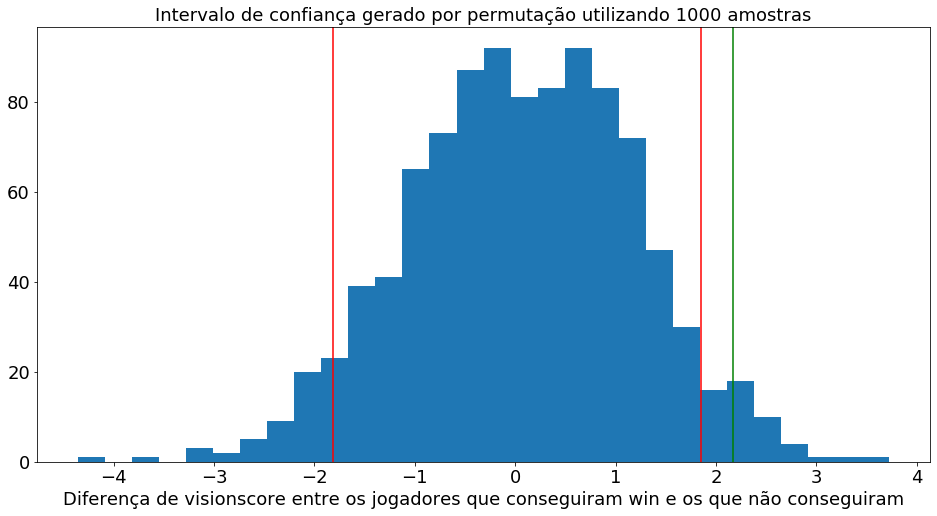

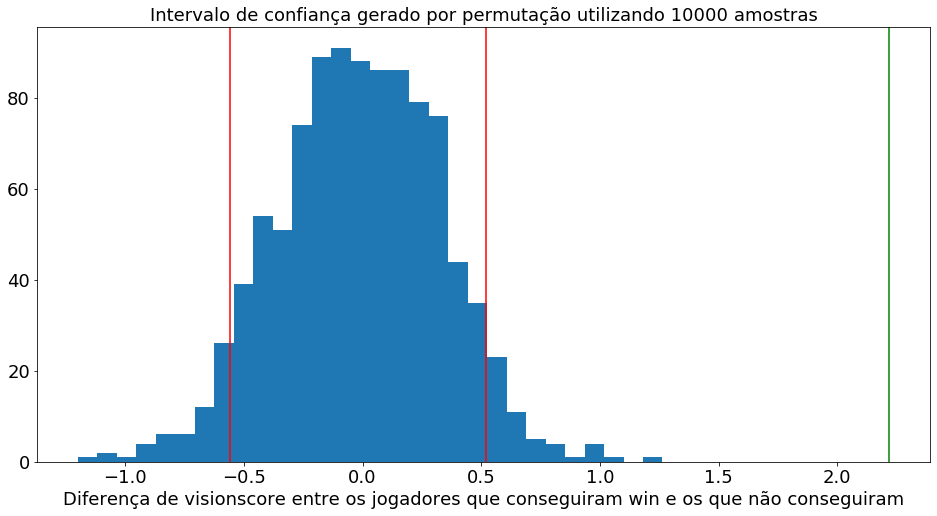

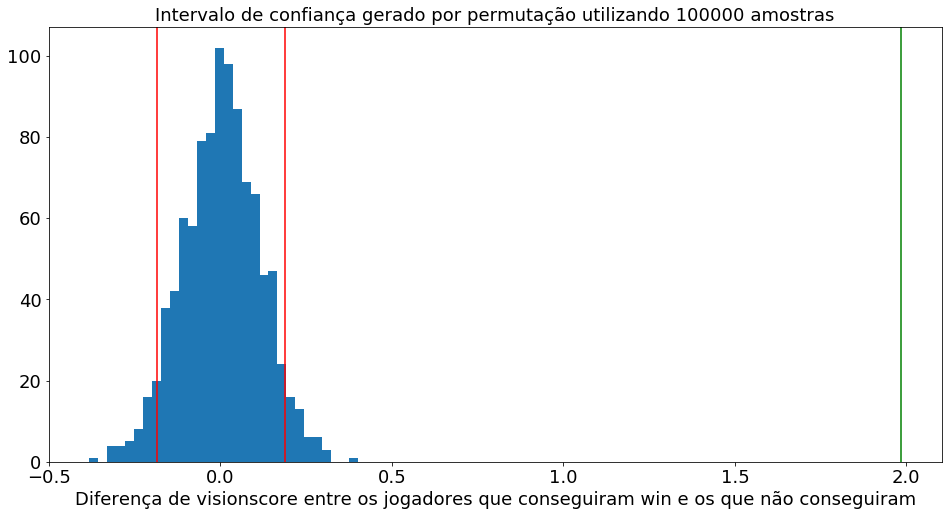

In [467]:
perm_diff2(df3, 'visionscore', 'win', 1000)
perm_diff2(df3, 'visionscore', 'win', 10000)
perm_diff2(df3, 'visionscore', 'win', 100000)

com 1000 amostras
diferença de pinksbought observada entre win e não win : 0.024672888223976175
iteracoes: 0/1000
iteracoes: 250/1000
iteracoes: 500/1000
iteracoes: 750/1000
com 10000 amostras
diferença de pinksbought observada entre win e não win : 0.14972404853827248
iteracoes: 0/1000
iteracoes: 250/1000
iteracoes: 500/1000
iteracoes: 750/1000
com 100000 amostras
diferença de pinksbought observada entre win e não win : 0.10416261587427578
iteracoes: 0/1000
iteracoes: 250/1000
iteracoes: 500/1000
iteracoes: 750/1000


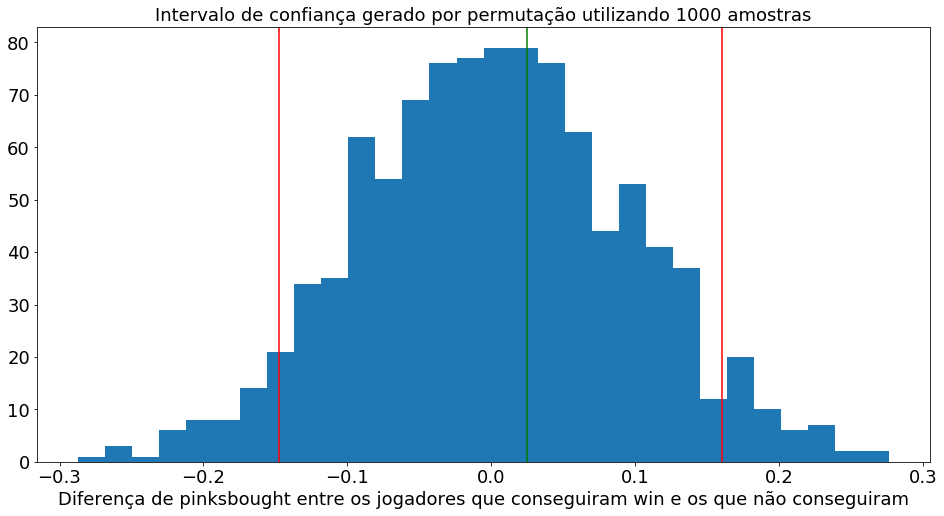

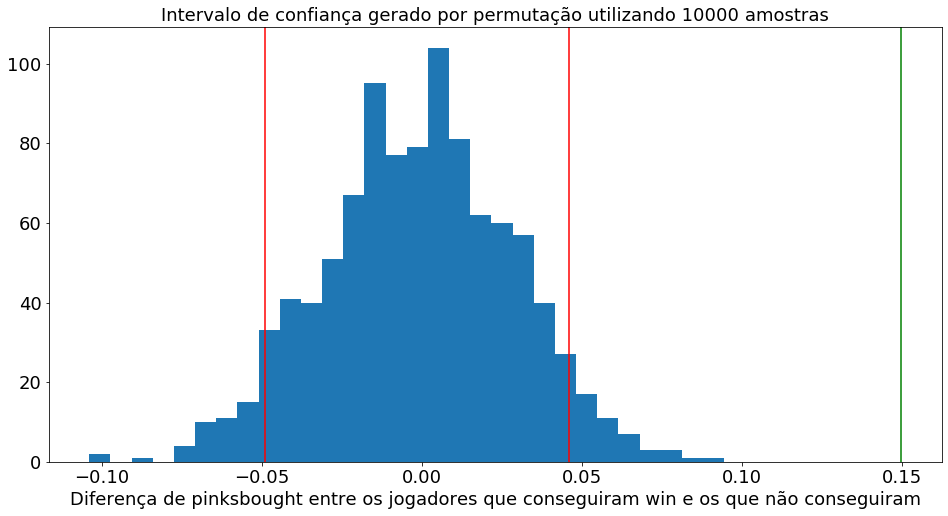

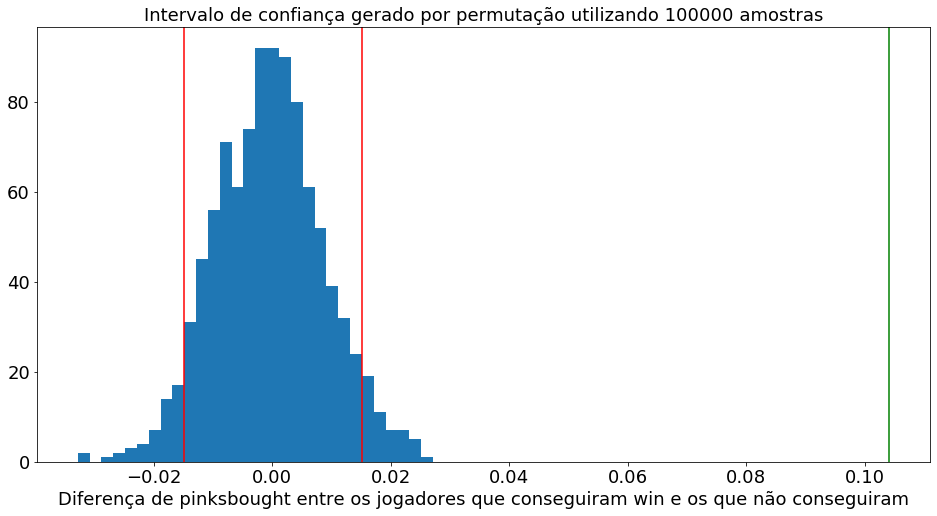

In [468]:
perm_diff2(df3, 'pinksbought', 'win', 1000)
perm_diff2(df3, 'pinksbought', 'win', 10000)
perm_diff2(df3, 'pinksbought', 'win', 100000)

com 1000 amostras
diferença de wardskilled observada entre win e não win : 0.2992047872765966
iteracoes: 0/1000
iteracoes: 250/1000
iteracoes: 500/1000
iteracoes: 750/1000
com 10000 amostras
diferença de wardskilled observada entre win e não win : 0.15448348694316438
iteracoes: 0/1000
iteracoes: 250/1000
iteracoes: 500/1000
iteracoes: 750/1000
com 100000 amostras
diferença de wardskilled observada entre win e não win : 0.16932639518019132
iteracoes: 0/1000
iteracoes: 250/1000
iteracoes: 500/1000
iteracoes: 750/1000


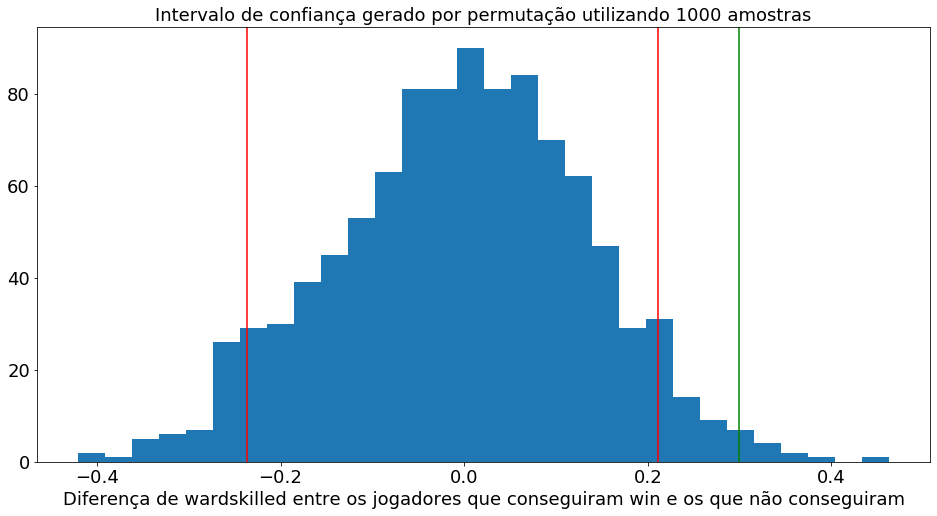

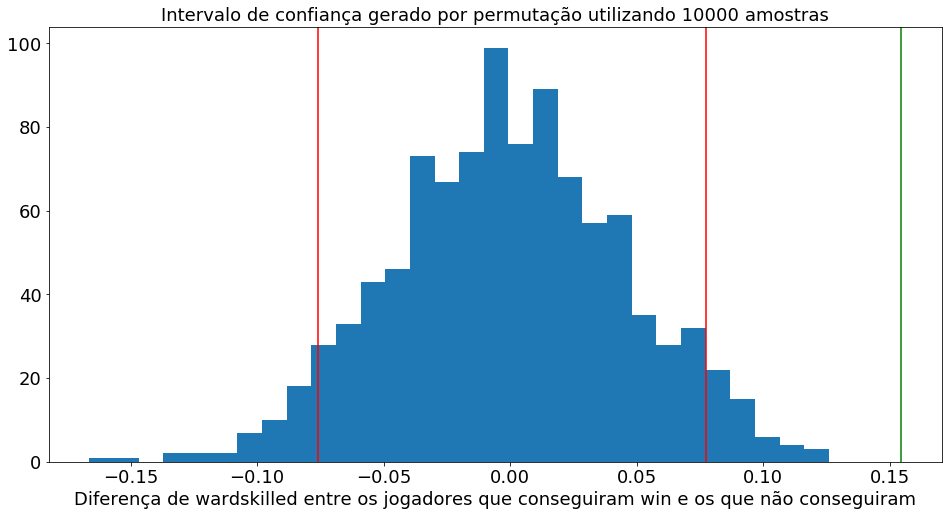

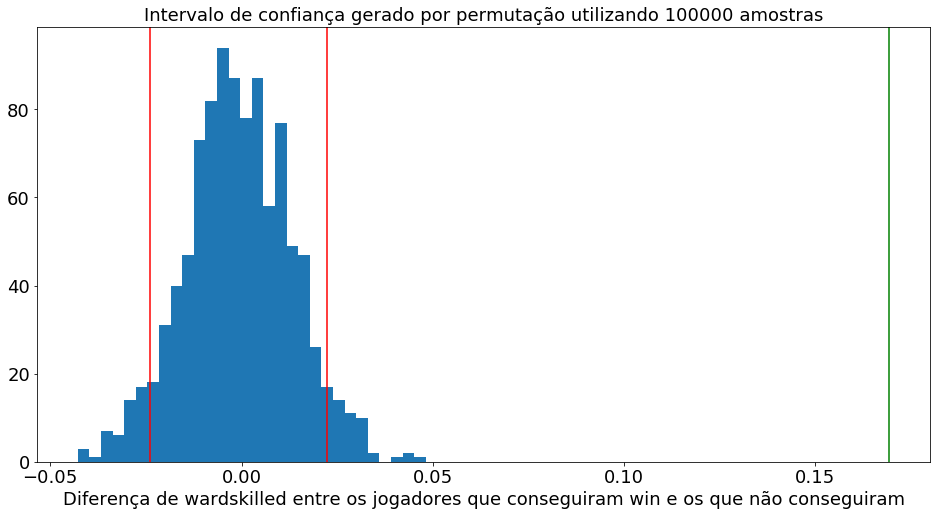

In [469]:
perm_diff2(df3, 'wardskilled', 'win', 1000)
perm_diff2(df3, 'wardskilled', 'win', 10000)
perm_diff2(df3, 'wardskilled', 'win', 100000)

## Análise da diferença de número de assistências entre a equipe vencedora e perdedora.

com 1000 amostras
diferença de assists observada entre win e não win : 4.266452345690904
iteracoes: 0/1000
iteracoes: 250/1000
iteracoes: 500/1000
iteracoes: 750/1000


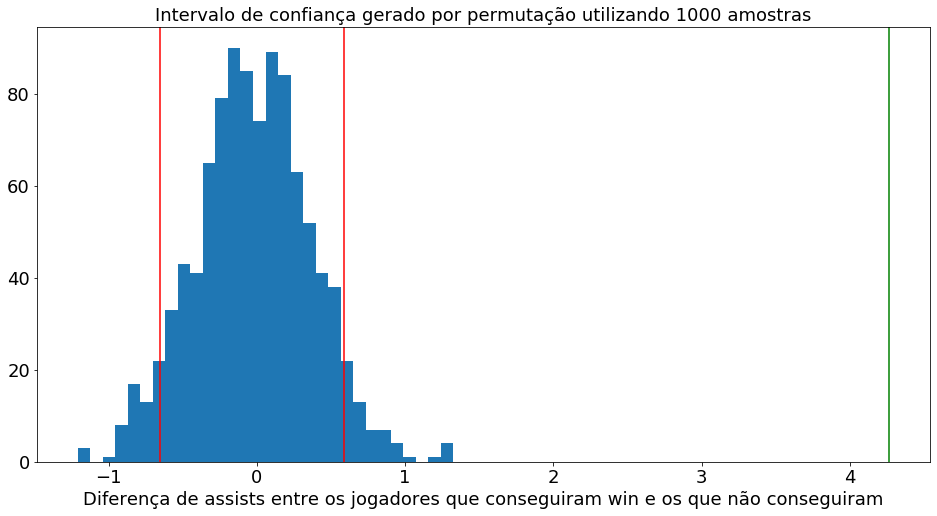

In [470]:
perm_diff2(df3, 'assists', 'win', 1000)

## Análise da diferença de ouro gasto entre a equipe vencedora e perdedora.

com 1000 amostras
diferença de goldspent observada entre win e não win : 1108.5628702514805
iteracoes: 0/1000
iteracoes: 250/1000
iteracoes: 500/1000
iteracoes: 750/1000


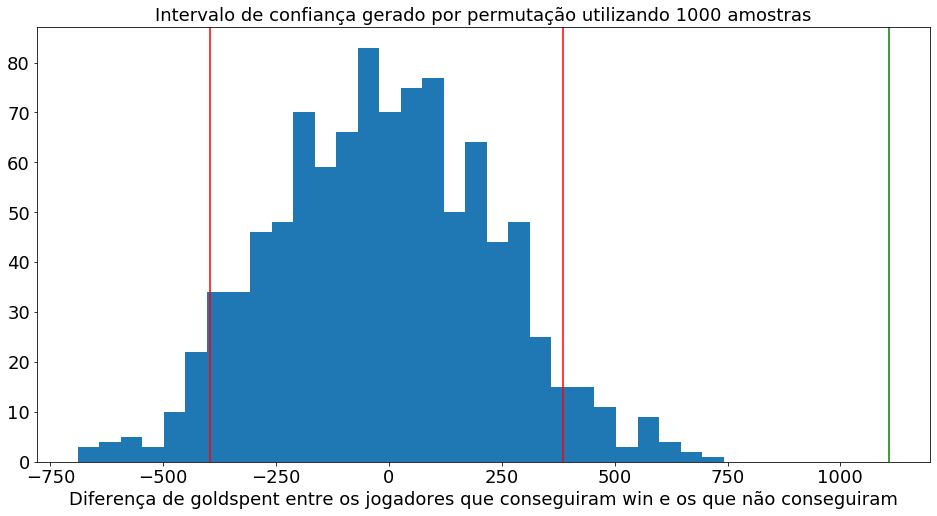

In [471]:
perm_diff2(df3, 'goldspent', 'win', 1000)

com 1000 amostras
diferença de totcctimedealt observada entre win e não win : 18.393017153097787
iteracoes: 0/1000
iteracoes: 250/1000
iteracoes: 500/1000
iteracoes: 750/1000
com 10000 amostras
diferença de totcctimedealt observada entre win e não win : 35.707316069229705
iteracoes: 0/1000
iteracoes: 250/1000
iteracoes: 500/1000
iteracoes: 750/1000


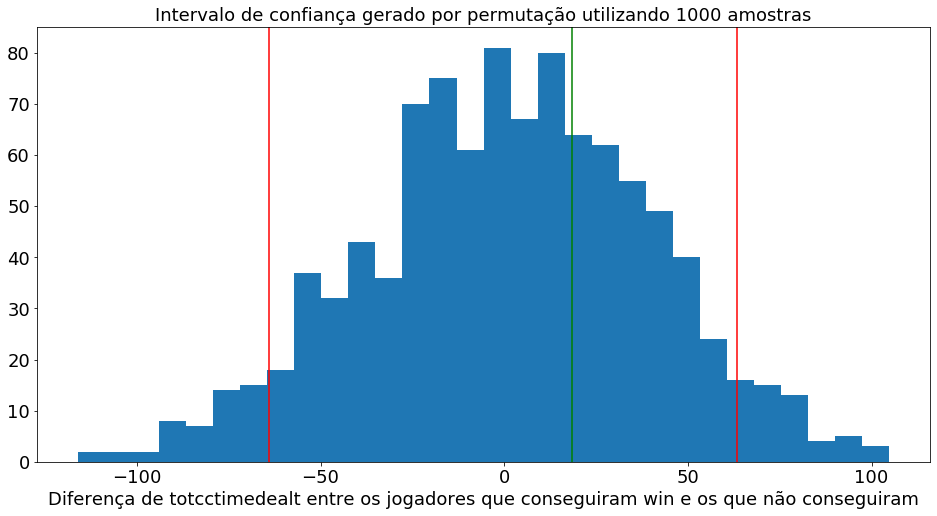

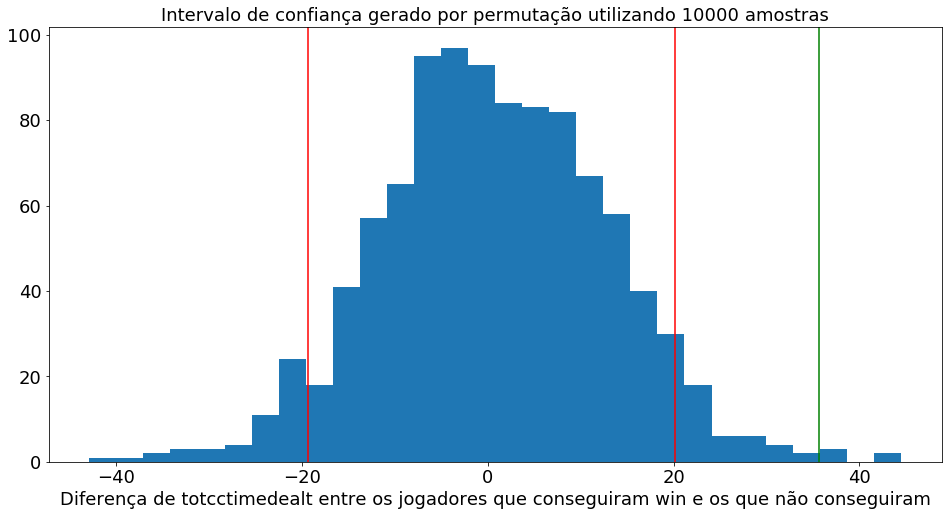

In [472]:
perm_diff2(df3, 'totcctimedealt', 'win', 1000)
perm_diff2(df3, 'totcctimedealt', 'win', 10000)